# Comparing results from SIMONA calculation against results of pandapower calculation
Positive values in difference indicate higher values within SIMONA.

In [3]:
# ===== Read in both results =====
import json
import os
from collections import defaultdict
from csv import DictWriter
from datetime import datetime
from math import sqrt

import numpy as np
from matplotlib import pyplot as plt
from numpy import mean

from tcv.calculation.result import GridResultThreeWinding, GridResultTwoWinding
from tcv.encoder import CustomDecoder
from tcv.encoder.DictEncoder import DictEncoder
from tcv.util import CsvFileWriter

result_directory = os.path.join("..", "..", "..", "..", "results", "two_winding")
simona_result_file = os.path.join(result_directory, "simona_tapLv.json")
pp_result_file = os.path.join(result_directory, "pp_tapLv.json")
diff_result_file = os.path.join(result_directory, "simona_vs_pandapower_tapLv.json")
diff_csv_file = os.path.join("..", "..", "..", "..", "csv", "two_winding", "%s_simona_vs_pp_tapLv_diff.csv") % datetime.strftime(
    datetime.now(), "%Y%m%d")
rmse_csv_file = os.path.join("..", "..", "..", "..", "csv", "two_winding", "%s_simona_vs_pp_tapLv_rmse.csv") % datetime.strftime(
    datetime.now(), "%Y%m%d")

# --- SIMONA results ---
if os.path.exists(simona_result_file):
    # The result file exists. Read it and use it
    print("Pre-calculated SIMONA results are available. Load them.")
    with open(simona_result_file, "r") as file_to_read:
        json_string = file_to_read.read()
        simona_results = json.loads(json_string, object_hook=CustomDecoder.custom_decode)
else:
    raise IOError("Unable to gather results of SIMONA.")

# --- pandapower results ---
if os.path.exists(pp_result_file):
    # The result file exists. Read it and use it
    print("Pre-calculated pandapower results are available. Load them.")
    with open(pp_result_file, "r") as file_to_read:
        json_string = file_to_read.read()
        pp_results = json.loads(json_string, object_hook=CustomDecoder.custom_decode)
else:
    raise IOError("Unable to gather results of pandapower.")

# ===== Bring together both results =====
if not len(simona_results) == len(pp_results):
    raise IOError("Uneven amount of results")

diff = []
p_lv_mw = []
for simona_result, pp_result in zip(simona_results, pp_results):
    # Some consistency checking
    if not simona_result['tap_pos'] == pp_result['tap_pos']:
        raise ValueError("Mismatch in results. Matched different tap positions")
    if abs(simona_result['p_lv'] - pp_result['p_lv']) > 0.1:
        raise ValueError(
            "Mismatch in results. Matched different low voltage powers. tap_pos: %i, Simona: %.3f MW, pandapower: %.3f MW" % (
                simona_result['tap_pos'], simona_result['p_lv'], pp_result['p_lv']))

    # Only register the input values in one tap position
    if simona_result['tap_pos'] == 0:
        p_lv_mw.append(simona_result['p_lv'])

    diff.append({
        'tap_pos': simona_result['tap_pos'],
        'p_lv': simona_result['p_lv'],
        'result': GridResultTwoWinding.subtract(simona_result['result'], pp_result['result'])
    })

# ===== Write results, if not yet done =====
if not os.path.exists(diff_result_file):
    with open(diff_result_file, "w") as file_to_write_to:
        print("Writing diff to file")
        json.dump(diff, file_to_write_to, cls=DictEncoder, indent=2)

# if not os.path.exists(diff_csv_file):
    # TODO: Adjust for line plot
    # CsvFileWriter.write_for_pgf_surf_plot(p_mv_tick_num=21, p_mv_rated_mw=300.0, p_lv_tick_num=21, p_lv_rated_mw=100.0,
    #                                       tap_range=range(-10, 11), result_json_path=diff_result_file,
    #                                       csv_file_path=diff_csv_file, col_sep=",")

# ===== Group results by tap position =====
tap_to_result = defaultdict(list)
for d in diff:
    tap_to_result[d['tap_pos']].append(d)

# ===== Calculate measures per tap =====
tap_to_error = []
tap_range = range(-10, 10 + 1)
tap_to_delta_v_mag_pu = {str(tap_pos): [] for tap_pos in tap_range}  # Voltage magnitude at low voltage node
tap_to_delta_v_ang_degree = {str(tap_pos): [] for tap_pos in tap_range}  # Voltage magnitude at low voltage node
for tap, results in tap_to_result.items():
    v_lv_pu = list(map(lambda r: r['result'].v_lv_pu, results))
    v_ang_lv_degree = list(map(lambda r: r['result'].v_ang_lv_degree, results))
    tap_to_delta_v_mag_pu[str(tap)] = v_lv_pu
    tap_to_delta_v_ang_degree[str(tap)] = v_ang_lv_degree

    delta_v_lv_max = max(v_lv_pu)
    delta_v_lv_min = min(v_lv_pu)
    delta_v_lv_avg = mean(v_lv_pu)
    delta_v_lv_rmse = sqrt(sum(map(lambda v: pow(v, 2), v_lv_pu)) / len(v_lv_pu))

    delta_v_ang_lv_max = max(v_ang_lv_degree)
    delta_v_ang_lv_min = min(v_ang_lv_degree)
    delta_v_ang_lv_avg = mean(v_ang_lv_degree)
    delta_v_ang_lv_rmse = sqrt(sum(map(lambda v: pow(v, 2), v_ang_lv_degree)) / len(v_ang_lv_degree))

    print(
        "Tap position: %i\n\tdelta_v\n\t\tmax\t= %.3e\n\t\tmin\t= %.3e\n\t\tavg\t= %.3e\n\t\trmse\t= %.3e\n\t"
        "delta_v_ang\n\t\tmax\t= %.3e\n\t\tmin\t= %.3e\n\t\tavg\t= t%.3e\n\t\trmse\t= t%.3e" % (
            tap, delta_v_lv_max, delta_v_lv_min, delta_v_lv_avg, delta_v_lv_rmse, delta_v_ang_lv_max, delta_v_ang_lv_min, delta_v_ang_lv_avg, delta_v_ang_lv_rmse))

    tap_to_error.append({
        'tap': tap,
        'delta_v_lv_rmse': delta_v_lv_rmse,
        'delta_v_ang_lv_rmse': delta_v_ang_lv_rmse
    })

# Write RMSE results to csv file
if not os.path.exists(rmse_csv_file):
    with open(rmse_csv_file, "w") as file_to_write_to:
        print("Writing RMSE to file")
        writer = DictWriter(file_to_write_to,
                            fieldnames=['tap', 'delta_v_lv_rmse', 'delta_v_ang_lv_rmse'])
        writer.writeheader()
        writer.writerows(tap_to_error)

Pre-calculated SIMONA results are available. Load them.
Pre-calculated pandapower results are available. Load them.
Tap position: -10
	delta_v
		max	= 2.872e-03
		min	= -3.592e-03
		avg	= -1.103e-04
		rmse	= 1.961e-03
	delta_v_ang
		max	= 7.974e-01
		min	= -8.298e-01
		avg	= t-6.429e-03
		rmse	= t4.923e-01
Tap position: -9
	delta_v
		max	= 2.968e-03
		min	= -3.712e-03
		avg	= -1.140e-04
		rmse	= 2.026e-03
	delta_v_ang
		max	= 7.974e-01
		min	= -8.298e-01
		avg	= t-6.429e-03
		rmse	= t4.923e-01
Tap position: -8
	delta_v
		max	= 3.063e-03
		min	= -3.831e-03
		avg	= -1.177e-04
		rmse	= 2.092e-03
	delta_v_ang
		max	= 7.974e-01
		min	= -8.298e-01
		avg	= t-6.429e-03
		rmse	= t4.923e-01
Tap position: -7
	delta_v
		max	= 3.159e-03
		min	= -3.951e-03
		avg	= -1.214e-04
		rmse	= 2.157e-03
	delta_v_ang
		max	= 7.974e-01
		min	= -8.298e-01
		avg	= t-6.429e-03
		rmse	= t4.923e-01
Tap position: -6
	delta_v
		max	= 3.255e-03
		min	= -4.071e-03
		avg	= -1.251e-04
		rmse	= 2.222e-03
	delta_v_ang
		max

## Visualize the error

Tap dependent voltage deviation

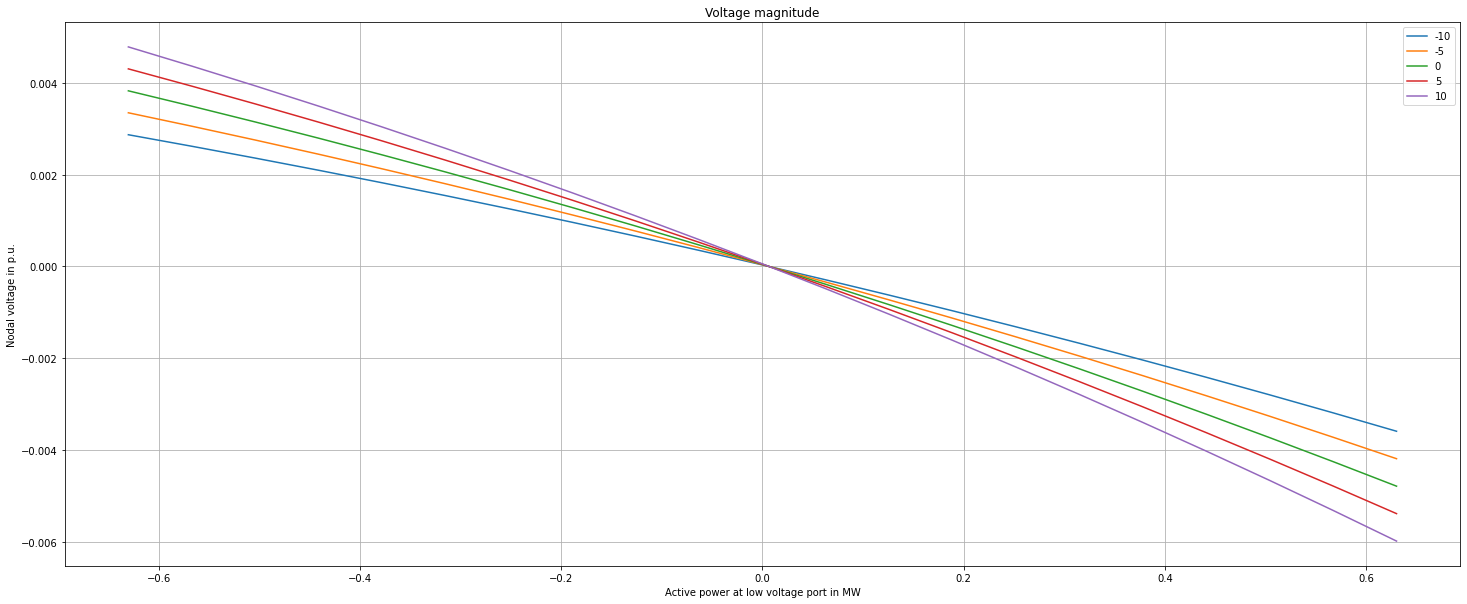

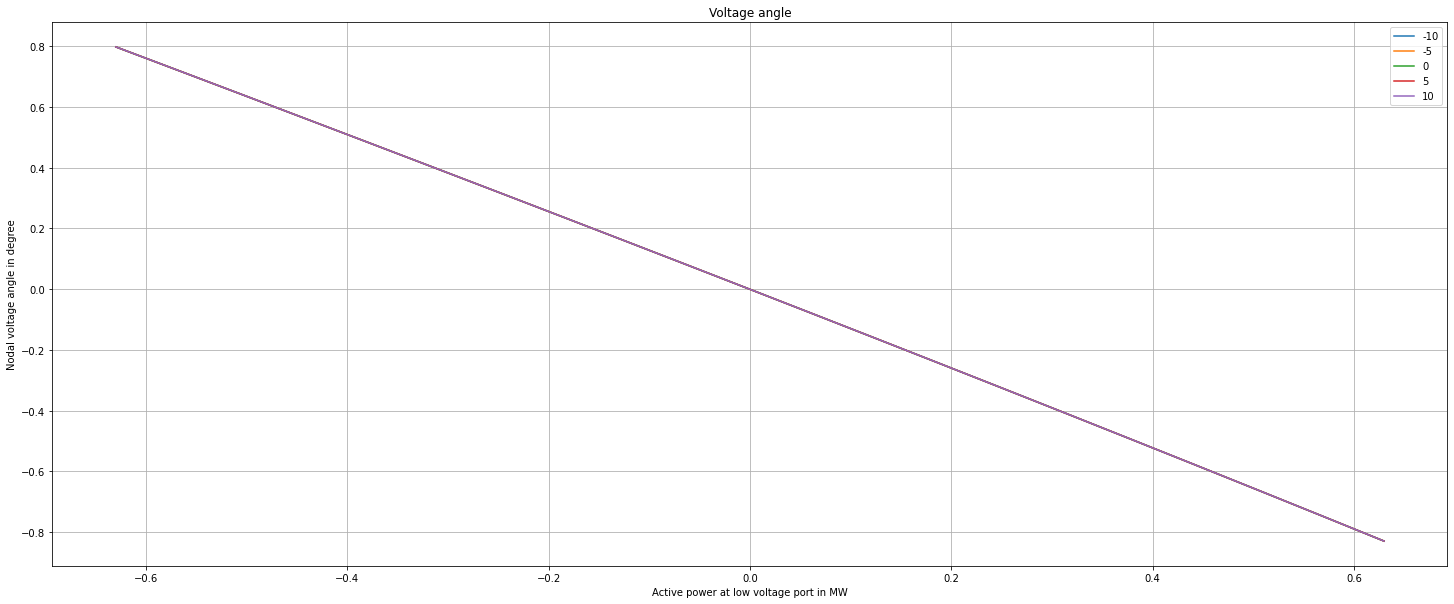

In [4]:
fig_tap_mag, ax_tap_mag = plt.subplots(figsize=(25, 10))
ax_tap_mag.set_title('Voltage magnitude')
ax_tap_mag.set_xlabel('Active power at low voltage port in MW')
ax_tap_mag.set_ylabel('Nodal voltage in p.u.')
ax_tap_mag.grid()
ax_tap_mag.plot(np.array(p_lv_mw), np.array(tap_to_delta_v_mag_pu['-10']), label='-10')
ax_tap_mag.plot(np.array(p_lv_mw), np.array(tap_to_delta_v_mag_pu['-5']), label='-5')
ax_tap_mag.plot(np.array(p_lv_mw), np.array(tap_to_delta_v_mag_pu['0']), label='0')
ax_tap_mag.plot(np.array(p_lv_mw), np.array(tap_to_delta_v_mag_pu['5']), label='5')
ax_tap_mag.plot(np.array(p_lv_mw), np.array(tap_to_delta_v_mag_pu['10']), label='10')
ax_tap_mag.legend()

fig_tap_ang, ax_tap_ang = plt.subplots(figsize=(25, 10))
ax_tap_ang.set_title('Voltage angle')
ax_tap_ang.set_xlabel('Active power at low voltage port in MW')
ax_tap_ang.set_ylabel('Nodal voltage angle in degree')
ax_tap_ang.grid()
ax_tap_ang.plot(np.array(p_lv_mw), np.array(tap_to_delta_v_ang_degree['-10']), label='-10')
ax_tap_ang.plot(np.array(p_lv_mw), np.array(tap_to_delta_v_ang_degree['-5']), label='-5')
ax_tap_ang.plot(np.array(p_lv_mw), np.array(tap_to_delta_v_ang_degree['0']), label='0')
ax_tap_ang.plot(np.array(p_lv_mw), np.array(tap_to_delta_v_ang_degree['5']), label='5')
ax_tap_ang.plot(np.array(p_lv_mw), np.array(tap_to_delta_v_ang_degree['10']), label='10')
ax_tap_ang.legend()